<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science </h1>

## Policing Project - Group #39

**Harvard University**<br/>
**Fall 2020**<br/>
**Team Members**: Chika Okafor, Vasco Meerman, Matthew Parker, and David Koupaei<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
<hr style='height:2px'>

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2020-CS109A/master/themes/static/css/cs109.css").text
HTML(styles)

In [2]:
# import the necessary libraries
import re
import requests
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from time import sleep
from bs4 import BeautifulSoup

# global properties
data_dir = "data/" # where to save data
num_search_pages = 50 # how many search pages to cull through

# NOTE:
# if you haven't yet downloaded the data, this should be set to True
download_data = False

## Disclaimer

[Input Project Description and Modified Research Questions]


## 1. Problem Overview 

[UPDATE THIS TEXT]
Whiskey is a type of alcohol, and there are many different types of whiskey, including **bourbon,** which will be the focus of this project. 

I am interested in determining:

1. Are there certain attributes of bourbons that are predictive of good (i.e., highly rated by users) bourbons?
    - Find hidden gems (i.e., should be good but current reviews are absent or unsupportive of such)
	- Find over-hyped whiskeys (i.e., the reviews seem high but the attributes aren't indicative)
	- Are there significant results if we target experts' ratings instead of average customer ratings?

2. Are there certain attributes of bourbons that are predictive of expensive bourbons?
    - Find under-priced whiskeys
    - Find over-priced whiskeys

3. Which bourbons are more similar to each other?
    - Which attributes are important for determining similarness? (e.g., does price play a role?)

## 2. Obtaining Data

[DESCRIBE DATA USED]

In [3]:
df = pd.read_csv('data/fatal-police-shootings-data-wsp.csv')
df

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,6245,Gregory Putnik,2020-10-18,shot,gun,32.0,M,W,Fresno,CA,False,attack,Foot,False,-119.821,36.758,True
5712,6247,Tutuila Pine Koonwaiyou,2020-10-18,shot,gun,37.0,M,NaN,Tooele,UT,False,other,Not fleeing,False,-112.298,40.531,True
5713,6242,NaN,2020-10-19,shot,gun,43.0,M,NaN,South Milwaukee,WI,False,attack,Not fleeing,False,-87.856,42.899,True
5714,6243,Paul Sulkowski,2020-10-19,shot,knife,46.0,M,NaN,Coram,NY,False,other,NaN,False,-73.010,40.875,True


In [37]:
# Add year to dataframe
df['year'] = pd.DatetimeIndex(df['date']).year

## 3. Data Sanity Check / Cleaning

What do our features look like? Are any features wonky, inconsistent, useless, or missing values?

<div class='exercise'><b>Let's use only the whiskeys that have been reviewed by experts</b>
</div>

In [4]:
df['manner_of_death'].value_counts()

shot                5427
shot and Tasered     289
Name: manner_of_death, dtype: int64

In [5]:
df['armed'].value_counts()

gun                    3252
knife                   846
unarmed                 359
toy weapon              193
undetermined            177
                       ... 
BB gun and vehicle        1
claimed to be armed       1
bottle                    1
pen                       1
vehicle and machete       1
Name: armed, Length: 95, dtype: int64

In [6]:
df['gender'].value_counts()

M    5463
F     252
Name: gender, dtype: int64

In [7]:
df['race'].value_counts()

W    2595
B    1345
H     947
A      94
N      81
O      47
Name: race, dtype: int64

In [8]:
df['signs_of_mental_illness'].value_counts()

False    4390
True     1326
Name: signs_of_mental_illness, dtype: int64

In [9]:
df['threat_level'].value_counts()

attack          3697
other           1763
undetermined     256
Name: threat_level, dtype: int64

In [10]:
df['flee'].value_counts()

Not fleeing    3567
Car             937
Foot            736
Other           186
Name: flee, dtype: int64

In [12]:
df['body_camera'].value_counts()

False    5029
True      687
Name: body_camera, dtype: int64

<div class='exercise'><b>Let's inspect the data types</b>
</div>

In [13]:
df.dtypes

id                           int64
name                        object
date                        object
manner_of_death             object
armed                       object
age                        float64
gender                      object
race                        object
city                        object
state                       object
signs_of_mental_illness       bool
threat_level                object
flee                        object
body_camera                   bool
longitude                  float64
latitude                   float64
is_geocoding_exact            bool
dtype: object

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

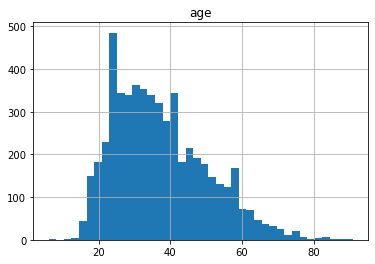

In [22]:
df.hist(column = 'age', bins='auto')

Let's cast our features to the correct data types and view summary statistics

In [23]:
df.describe()

,id,age,longitude,latitude
count,5716.000000,5456.000000,5437.000000,5437.000000
mean,3173.216235,37.139113,-97.256366,36.650508
std,1789.492388,13.068117,16.629368,5.367021
min,3.000000,6.000000,-158.137000,19.498000
25%,1624.750000,27.000000,-112.134000,33.477000
50%,3174.500000,35.000000,-94.432000,36.100000
75%,4734.250000,46.000000,-83.066000,39.958000
max,6247.000000,91.000000,-68.014000,71.301000


## 4. EDA
Now that our data is cleaned, let's explore it and try to understand any patterns. This understanding will impact our modelling choices. Based on the `.describe()` statistics above, let's first look at the most extreme values of features that seem a bit lopsided in their distribution of values.

In [59]:
df['armed_cat'] = df['armed'].astype('category').cat.codes
df['race_cat'] = df['race'].astype('category').cat.codes
df['threat_level_cat'] = df['threat_level'].astype('category').cat.codes
df['flee_cat'] = df['flee'].astype('category').cat.codes

<div class='exercise'>Where do they come from? Intent is to see if there are any errors or something worth noting.

In [26]:
df['state'].value_counts()

CA    853
TX    506
FL    379
AZ    262
CO    209
GA    197
OK    171
NC    168
WA    163
OH    159
TN    149
MO    146
LA    116
PA    113
NM    112
IL    109
NY    105
AL    105
NV    104
KY    103
IN    101
VA     97
WI     96
SC     93
OR     87
MI     86
AR     84
MD     81
NJ     71
UT     70
MS     67
MN     64
WV     56
KS     52
ID     43
AK     40
IA     36
MA     35
MT     34
HI     30
NE     25
ME     22
CT     21
SD     17
DC     14
WY     14
DE     13
NH     13
ND     12
VT      9
RI      4
Name: state, dtype: int64

In [38]:
df['year'].value_counts()

2019    999
2015    994
2018    990
2017    986
2016    962
2020    785
Name: year, dtype: int64

<div class='exercise'>Let's look for any patterns/correlations that may exists between our features. Since some of the above flavors are skewed (e.g., `Salty` is usually 0), we would not be able to discern any meaningful trend, so we can throw this out from our visualization. Otherwise, our graph woud just be a bunch of points overlapping one another at the 0 value.

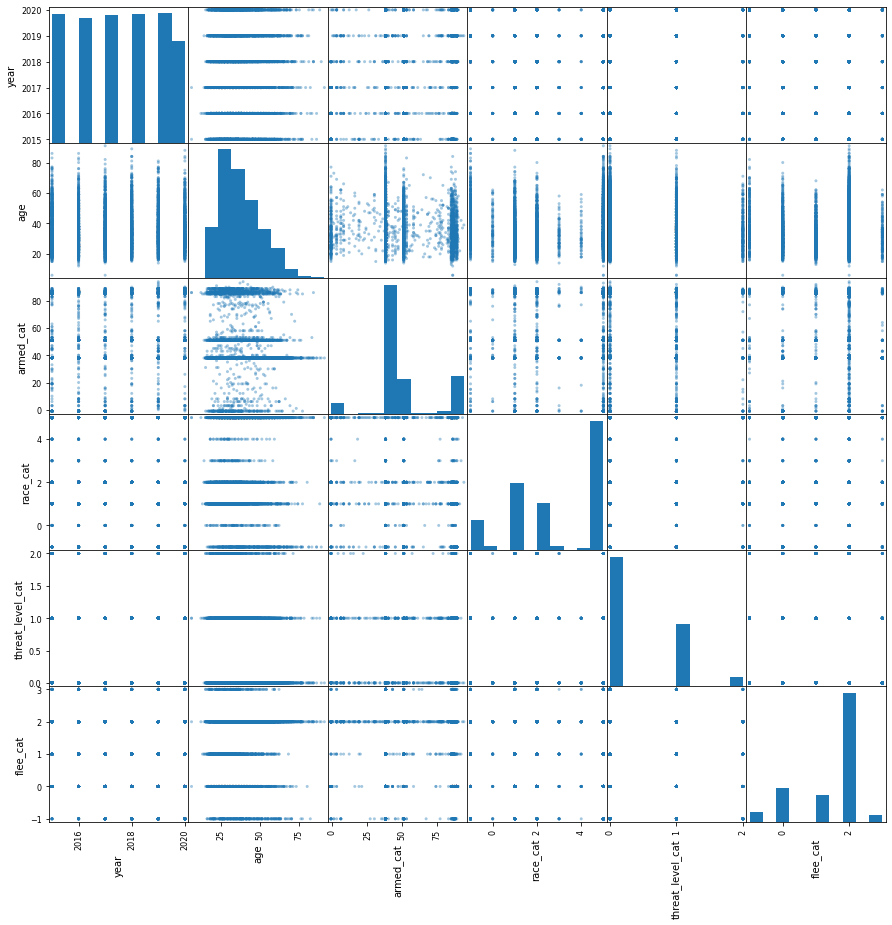

In [63]:
grid_features = ['year', 'age', 'armed_cat', "race_cat", "threat_level_cat", "flee_cat"]

scatter = pd.plotting.scatter_matrix(df[grid_features], alpha=0.4, figsize=(15,15));
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 90)